In [107]:
#pip install mpld3

In [108]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import glob
import os
#from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
#import mpld3
#mpld3.enable_notebook()

In [109]:
%matplotlib inline
plt.rcParams.update({'font.size': 15})

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


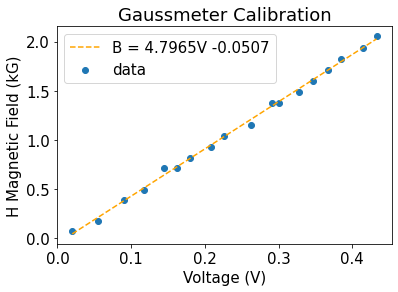

In [110]:
df_calibration = pd.read_csv('GaussmeterCalibration.csv')
df_calibration = df_calibration.rename(columns={'-0.052': 'Voltage', '-0.3137': 'B Field'})


def func(x, m, b):
    return m*x +b

(popt), pcov = curve_fit(func, df_calibration['Voltage'], df_calibration["B Field"])
 
plt.plot(df_calibration['Voltage'], func(df_calibration['Voltage'], *popt), '--',c='orange',label = f'B = {round(popt[0],4)}V {round(popt[1],4)}')
plt.scatter(df_calibration['Voltage'], df_calibration["B Field"],label='data')

m,b = popt

print(type(df_calibration["Voltage"]))
print(type(popt))
         
plt.xlabel("Voltage (V)")
plt.ylabel("H Magnetic Field (kG)")
plt.title("Gaussmeter Calibration")
plt.legend()

<ipython-input-111-7b5295f5c0af>:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


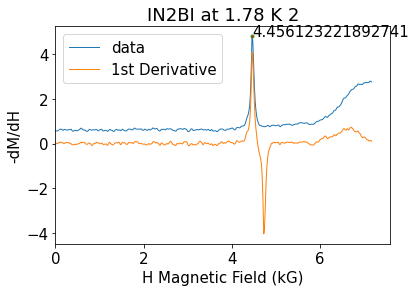

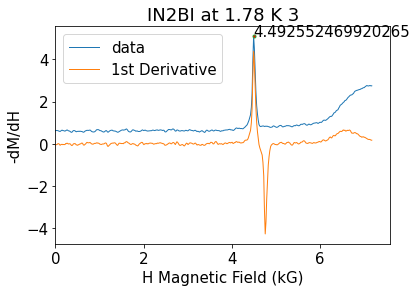

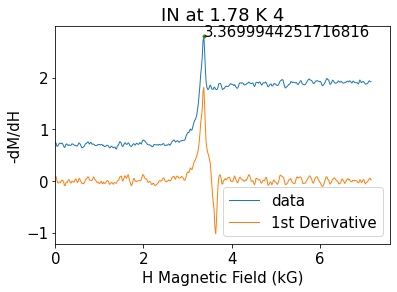

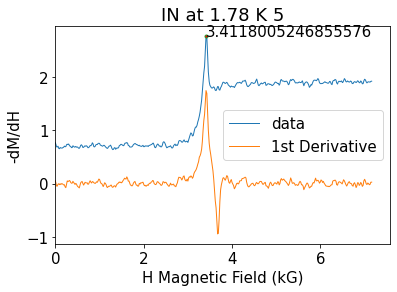

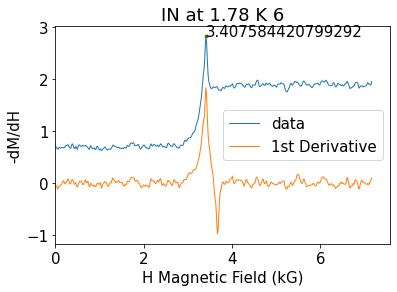

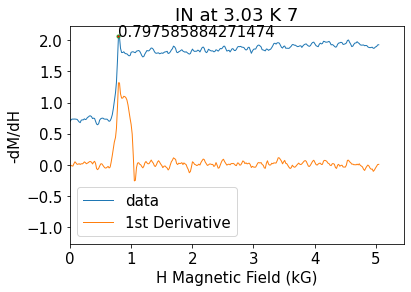

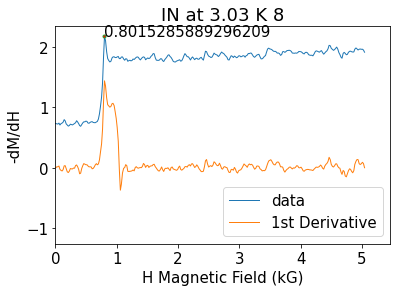

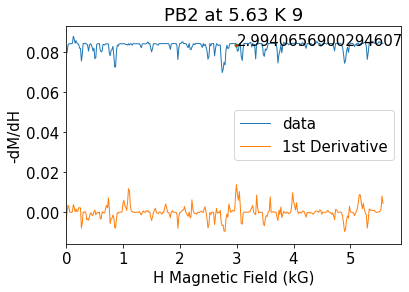

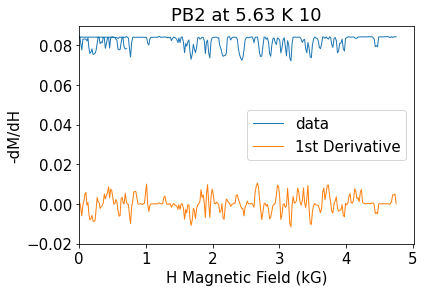

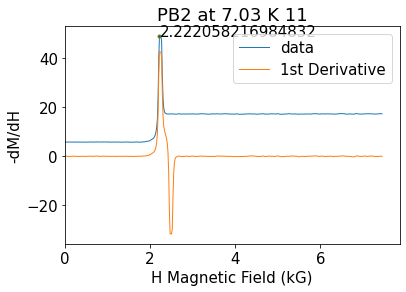

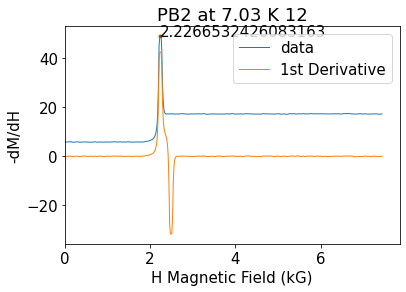

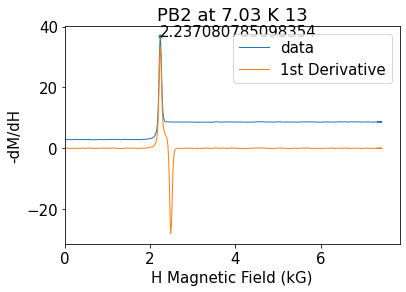

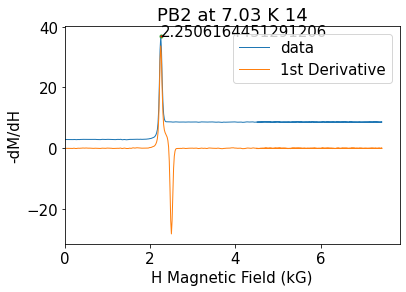

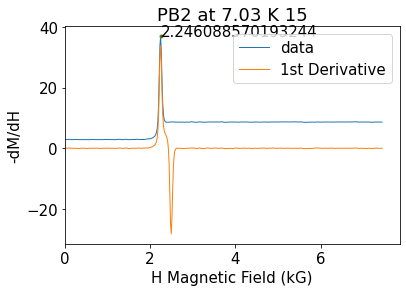

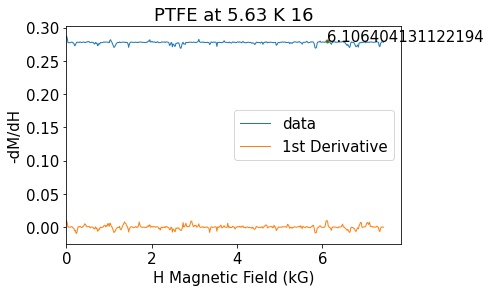

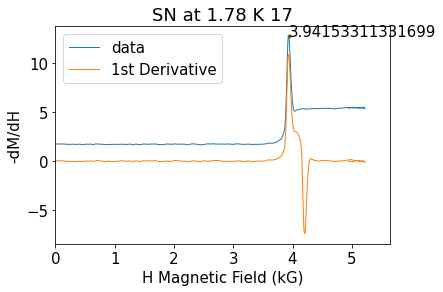

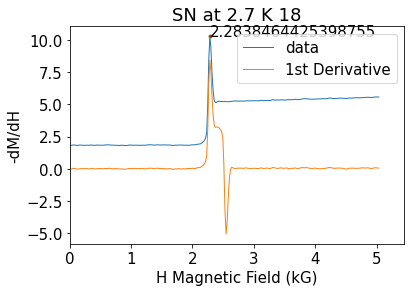

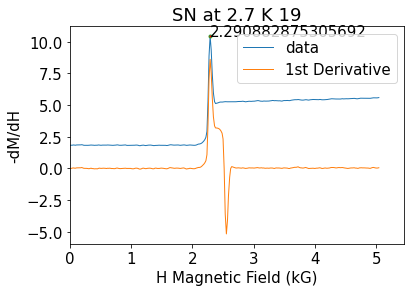

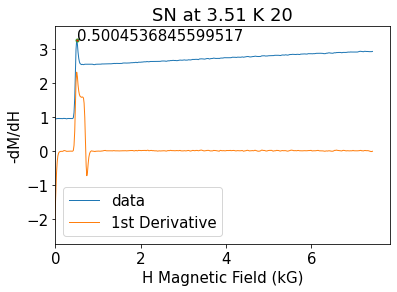

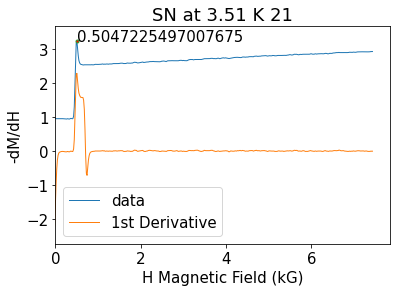

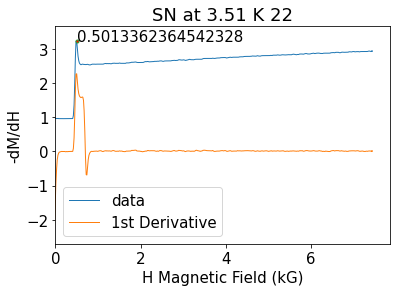

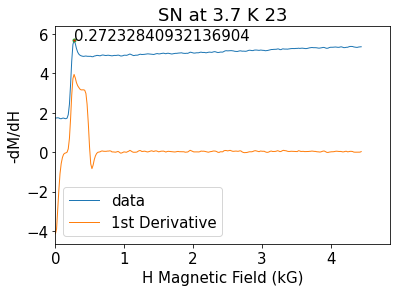

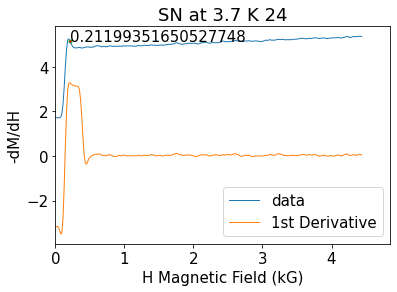

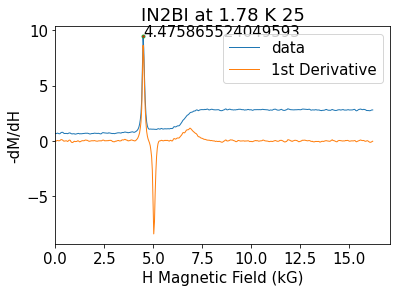

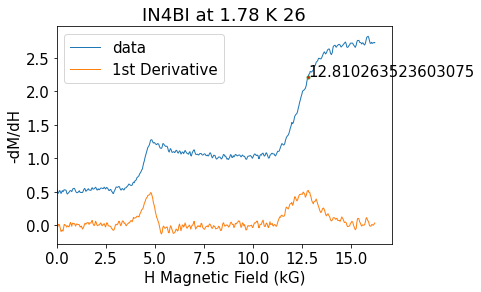

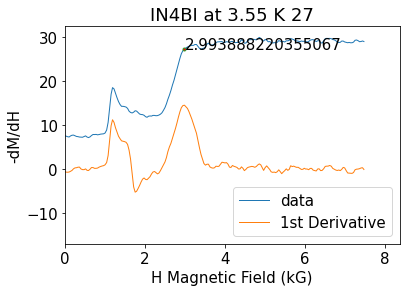

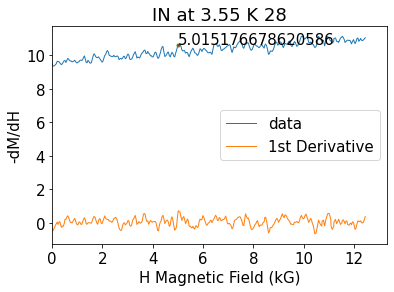

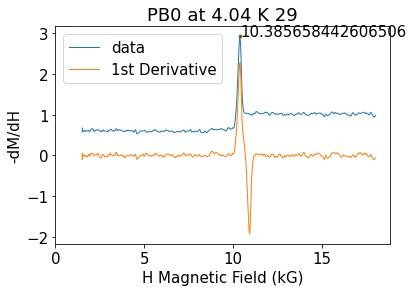

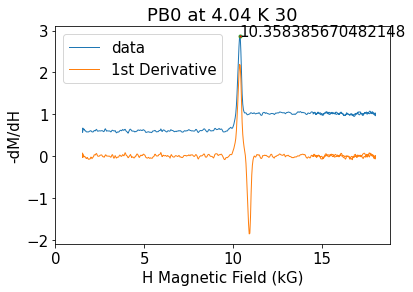

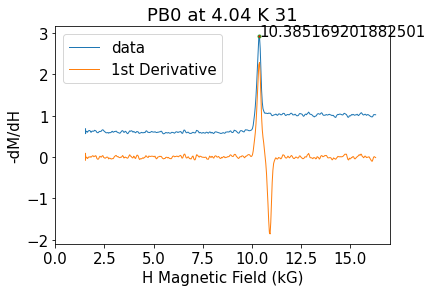

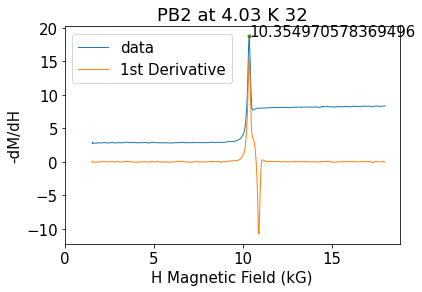

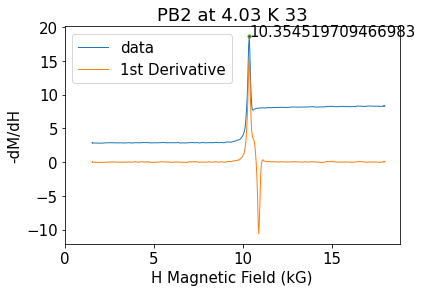

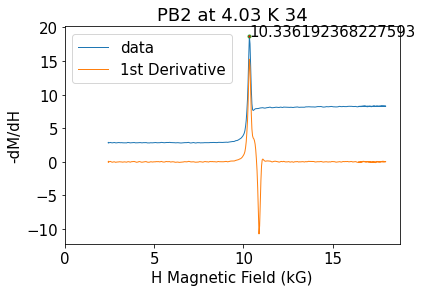

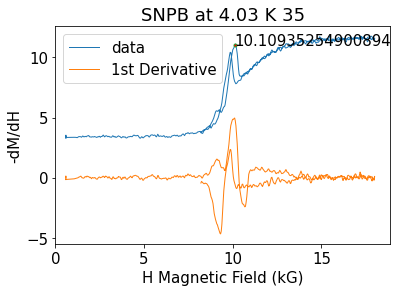

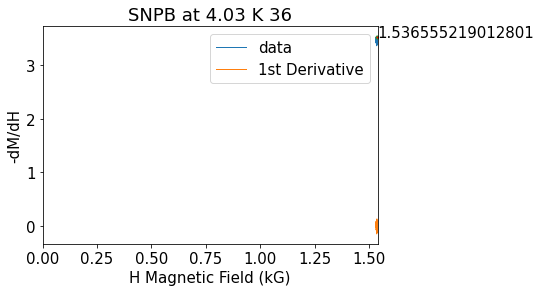

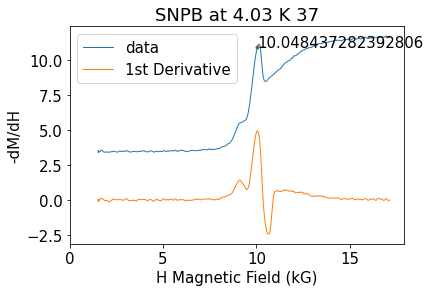

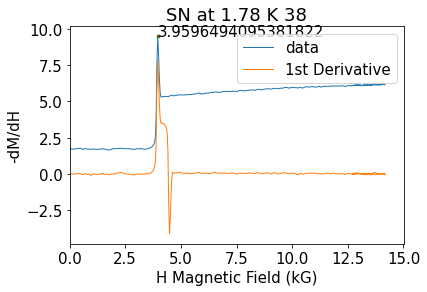

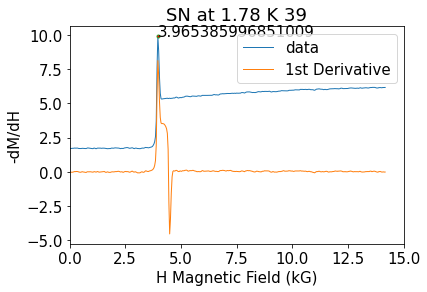

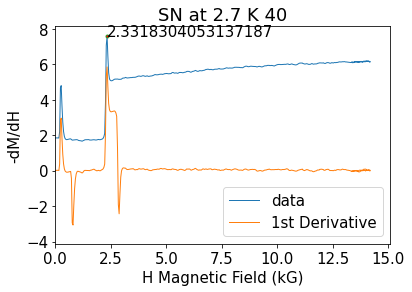

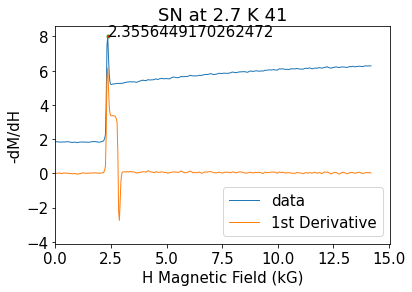

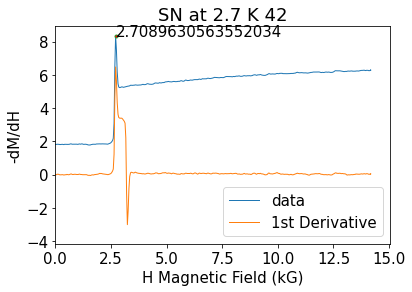

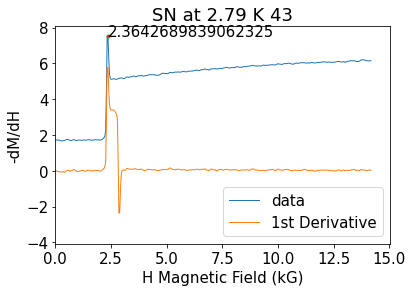

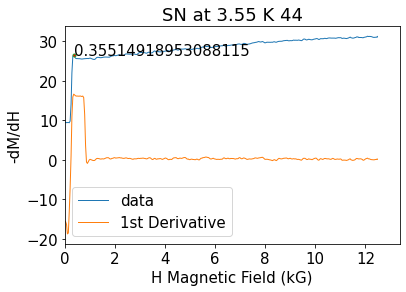

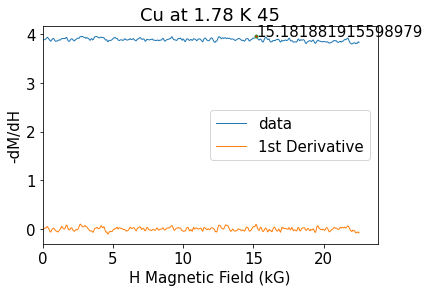

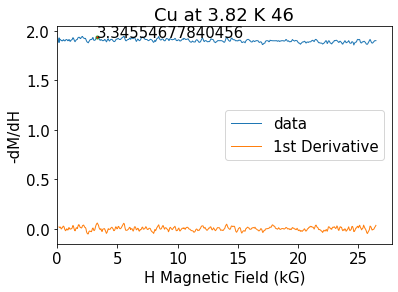

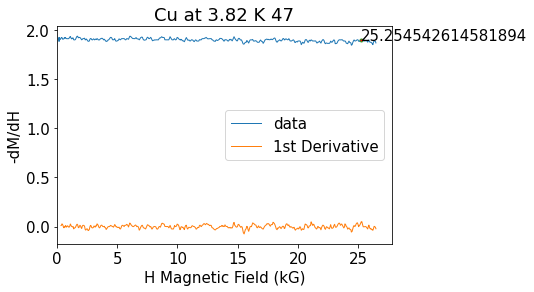

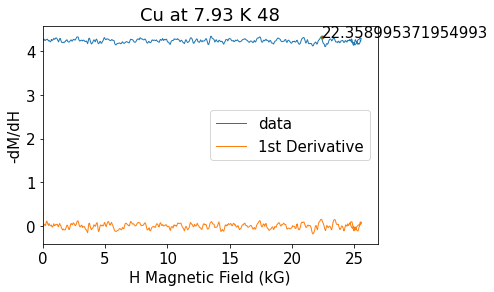

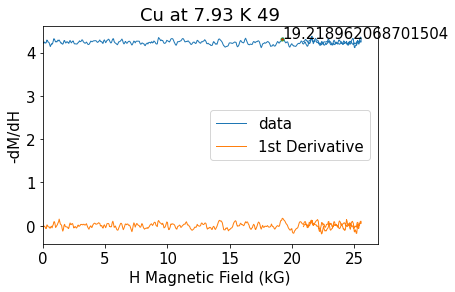

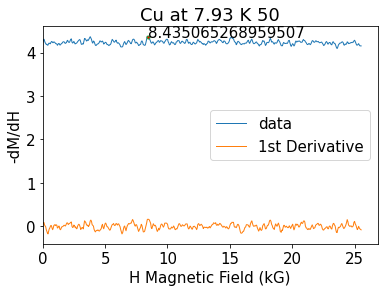

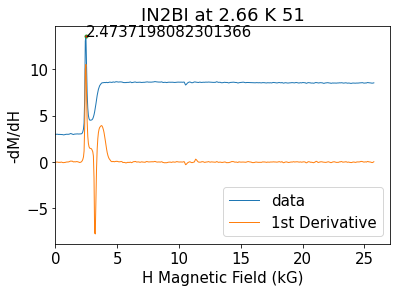

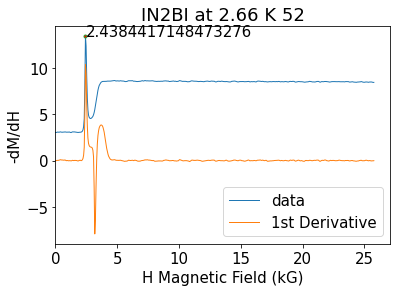

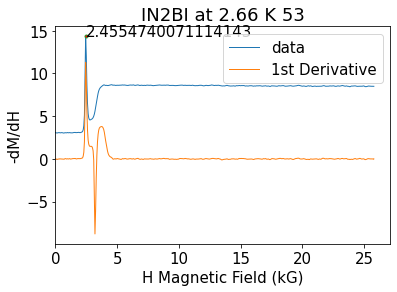

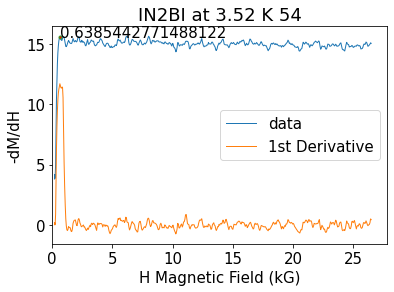

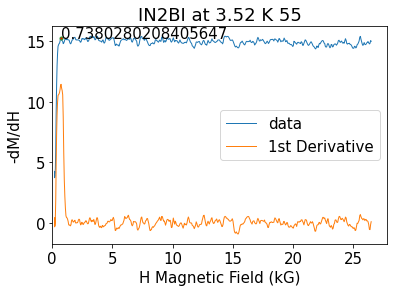

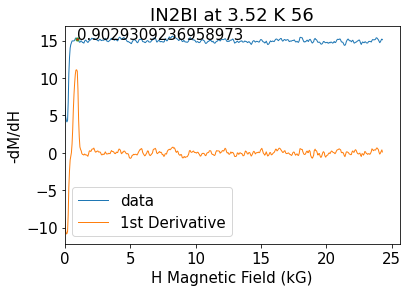

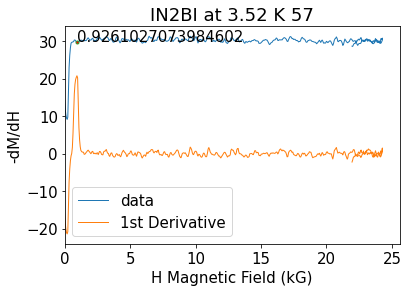

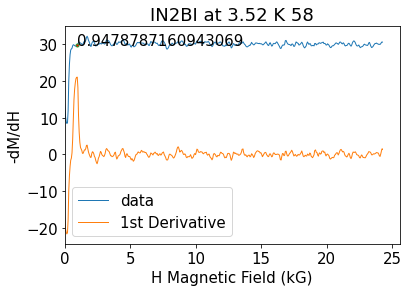

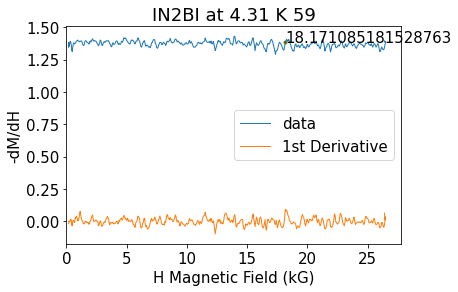

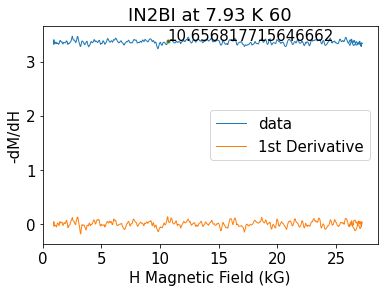

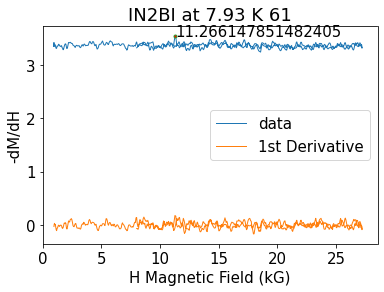

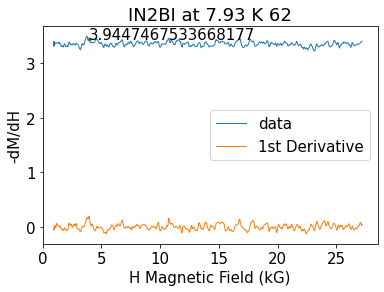

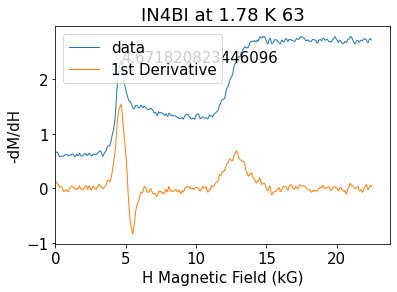

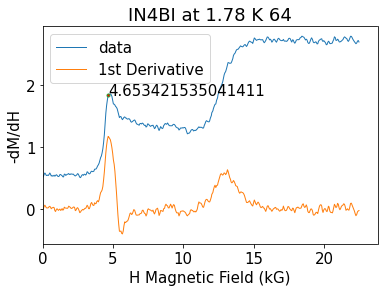

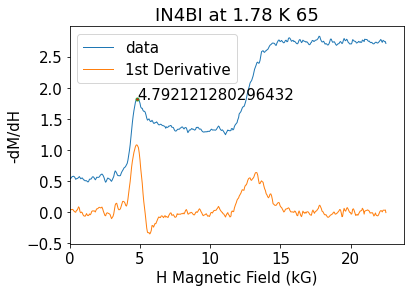

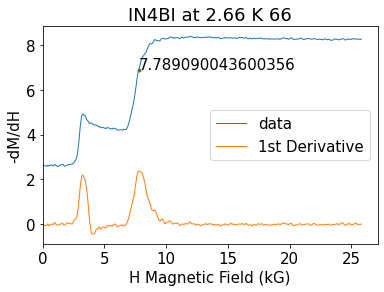

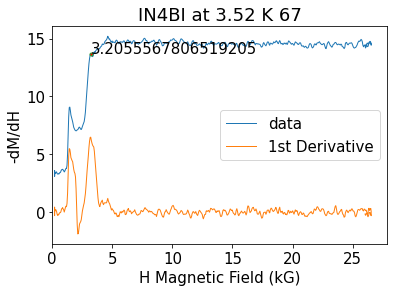

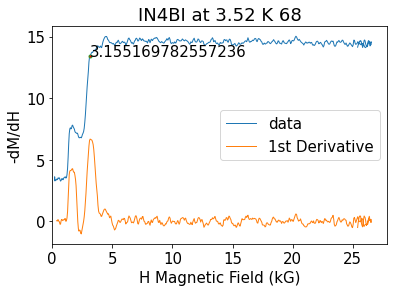

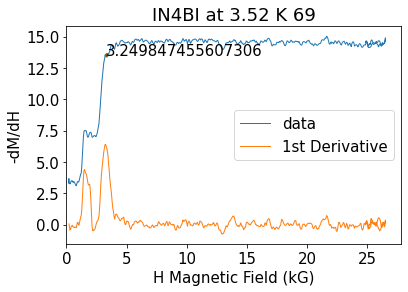

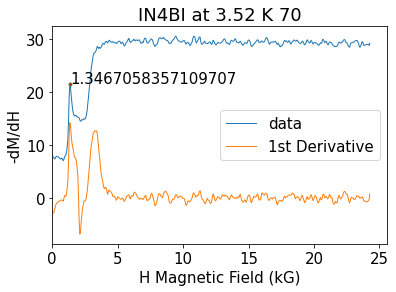

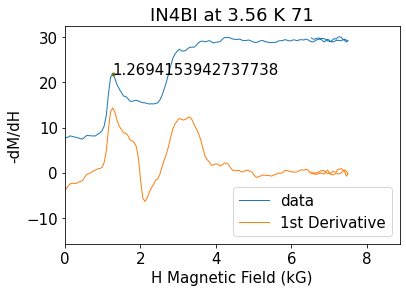

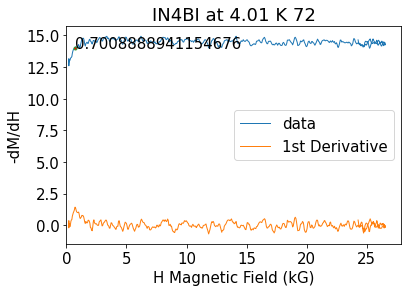

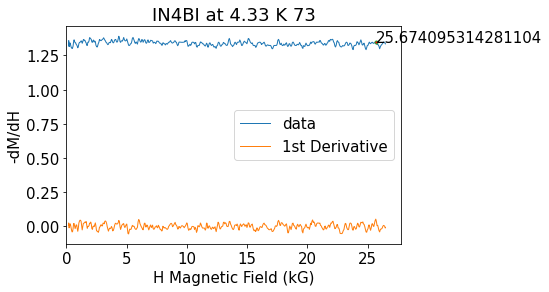

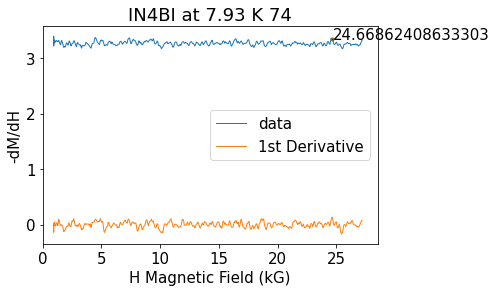

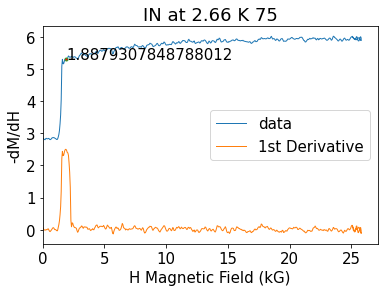

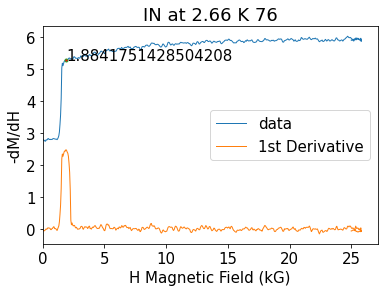

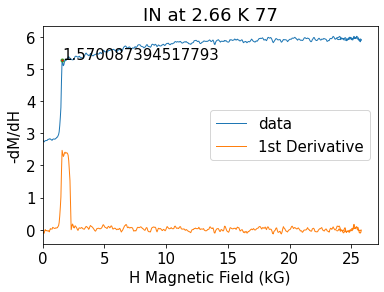

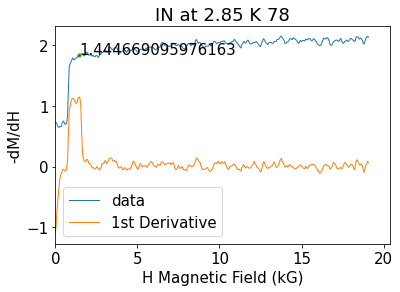

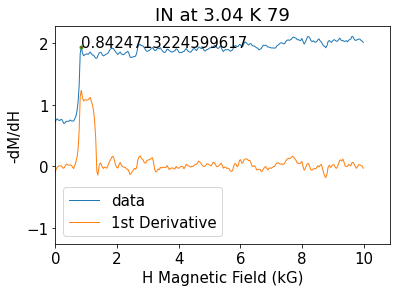

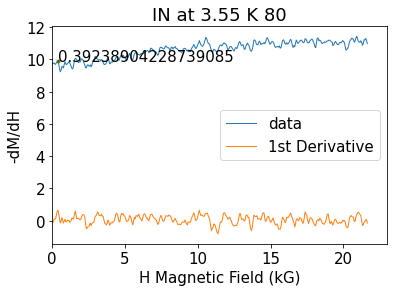

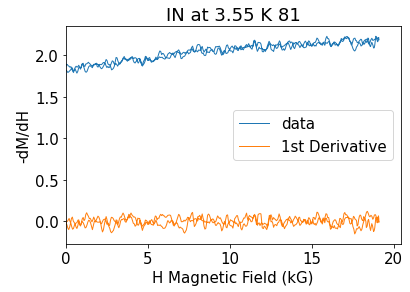

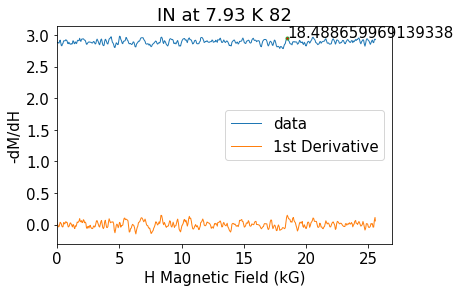

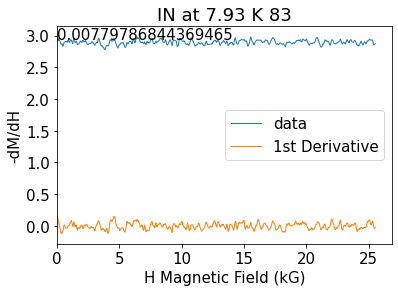

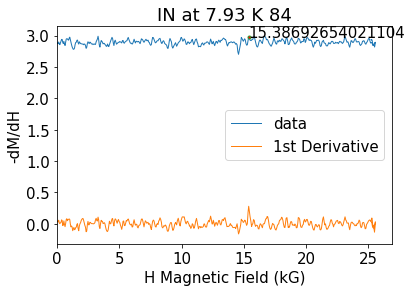

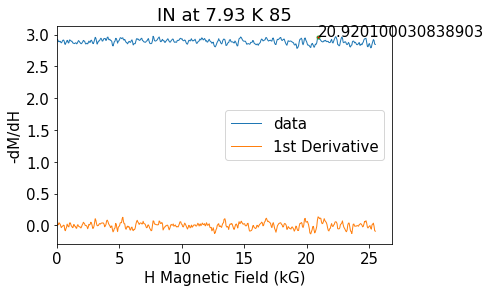

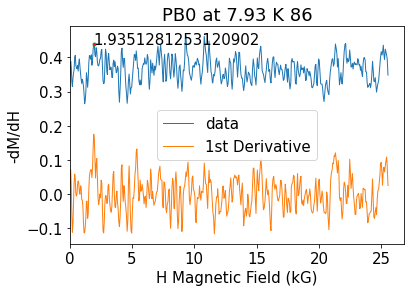

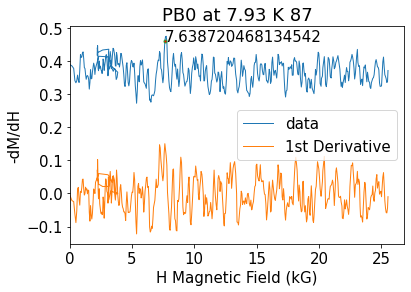

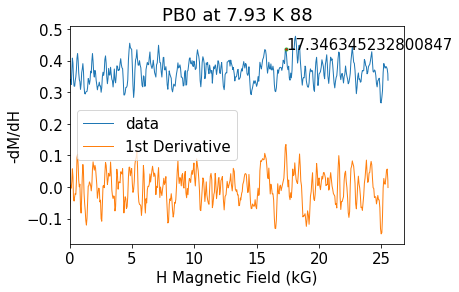

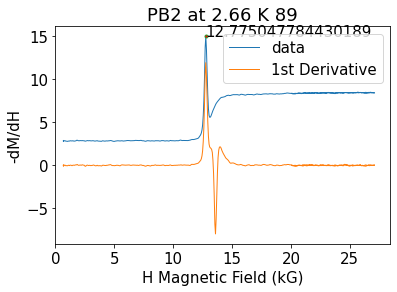

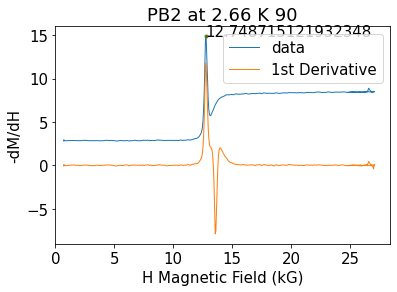

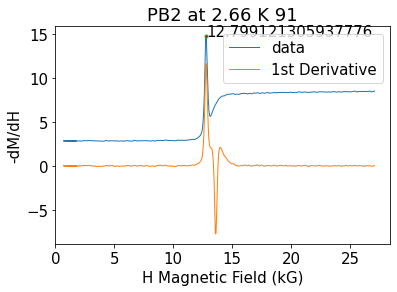

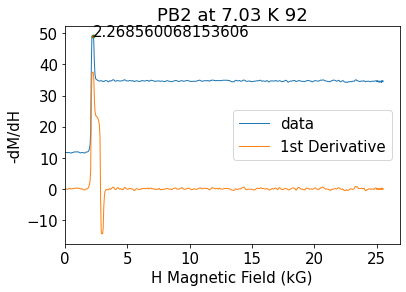

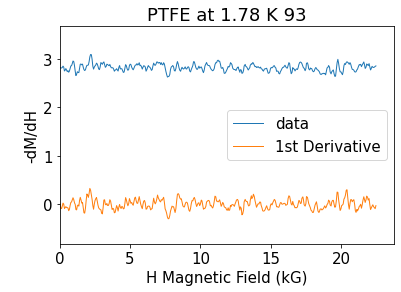

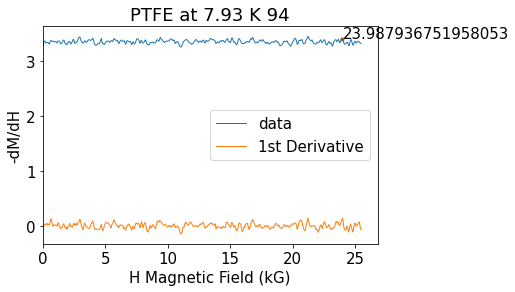

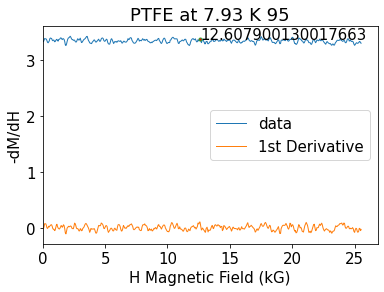

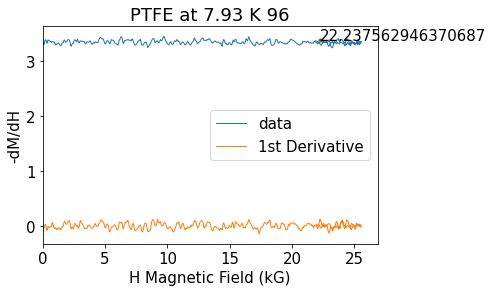

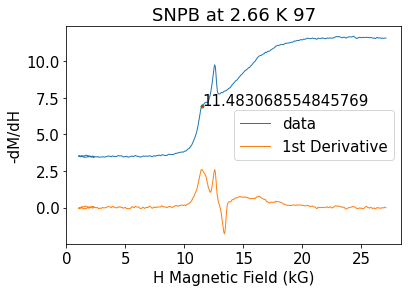

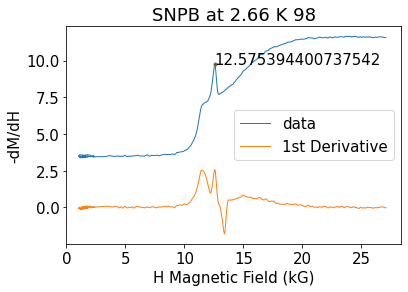

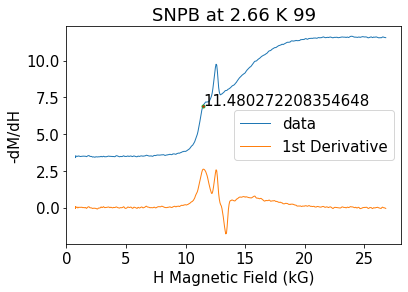

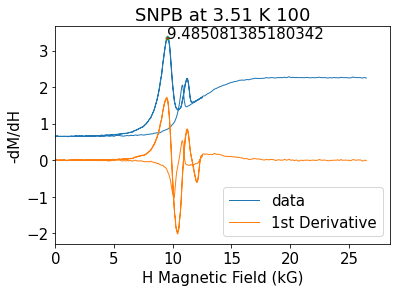

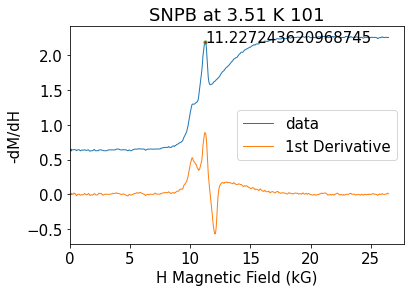

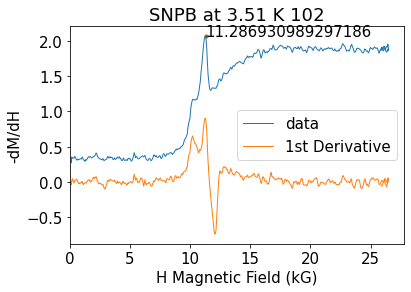

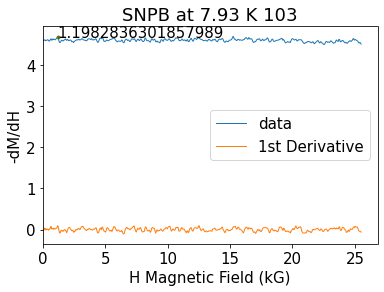

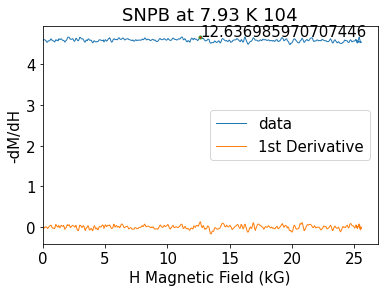

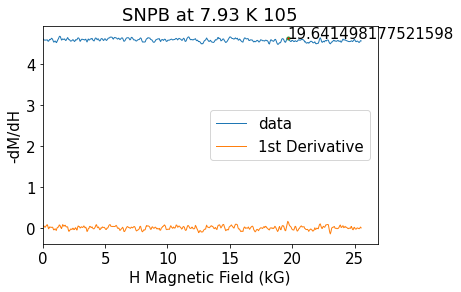

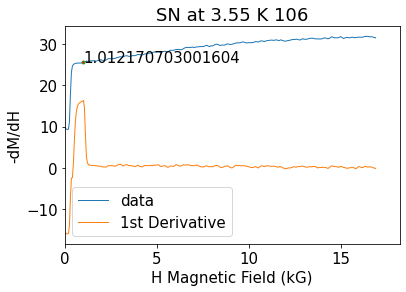

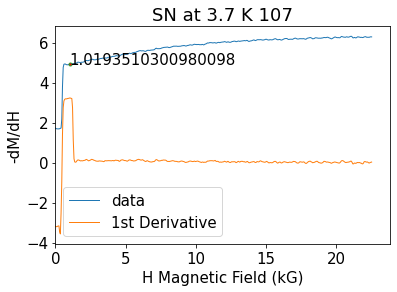

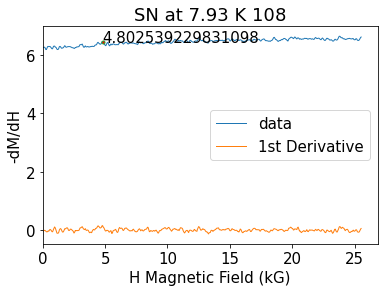

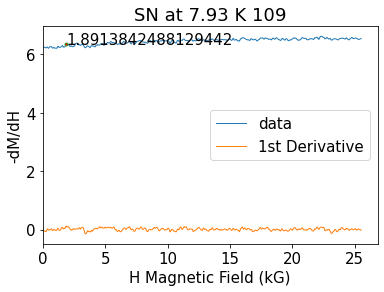

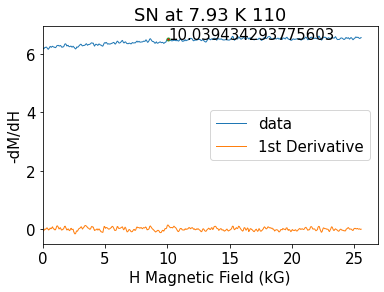

In [111]:
#### determinr HC at zero temperature and Tc by doing a fit 
files = glob.glob('*.txt')
files.sort()


list_samples = []
list_temperatures = []
list_critical_B = []

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

for i, file in enumerate(files):   
    df = pd.read_table(file,names = ['v0','v1','v2','v3'])
    
    #dropping the second half of the sweep down (hysterisis) because the way down often doesn't even have a peak 
    try: 
        row_drop1 = df[df['v0']== max(df['v0'])].index[0]
    except IndexError: 
        row_drop1 = int(len(df['v0'])/2) #if there is an nan error, just takes the half of the length of the total series 

    row_drop2 = len(df['v0'])
    df = df.drop(labels=range(row_drop1, row_drop2), axis=0)
    
    df = df.dropna()
    df = m*df + b
    
    
    
    #finding second derivative in order to find the peaks in the voltage vs. magnetic field 
    first_derivative = df.diff(periods = 15)
    #second_derivative = first_derivative.diff(periods = 15)
    #df['2derivative'] = second_derivative['v1']
    df['1derivative'] = first_derivative['v1'] 
    ######df['smooth'] = df['v1'].rolling(window=10).mean()
    #df['smooth'] = scipy.signal.savgol_filter(df['v1'], 11, 3 )
    
    
    #peak_position = find_peaks(df['v1'], height = .001 , threshold = .001, distance = 400 )
    #peak_position = peak_position[0][0]
    #print(peak_position)
    
    
    peak_position = df['1derivative'].idxmax() #x axis position
    
    #peak_value_1 = df.nlargest(1, columns = "1derivative")
    #peak_value_2 = df.nlargest(2, columns = "1derivative" )
    #peak_position = df.loc[df['v1'] == peak_value_1]
    #peak_position_2 = df.loc[df['v1'] == peak_value_2]
    #print(peak_position)
    
    

    
    index1_temp = find_nth(file, "_", 2) + 1
    index2_temp = find_nth(file, "K", 1)
    
    index1_name = find_nth(file, "_", 1) + 1 
    index2_name = find_nth(file, "_", 2) 
    
    sample_temperature = file[index1_temp:index2_temp]
    sample_name = file[index1_name: index2_name]

    
    if sample_name == "PTFE" and index2_temp == -1:
        index1_temp = find_nth(file, "_", 2) + 1
        index2_temp = find_nth(file, "T", 2)
        sample_temperature = file[index1_temp:index2_temp]
        
        if float(sample_temperature) == 115e-1: 
            sample_temperature = 1.78
        elif float(sample_temperature) == 450: 
            sample_temperature = 3.7
 
    if index2_temp == -1: 
        index1_temp = find_nth(file, "_", 2) + 1
        index2_temp = find_nth(file, "T", 1)
        sample_temperature = file[index1_temp:index2_temp]

        if float(sample_temperature) == 115e-1: 
            sample_temperature = 1.78
        elif float(sample_temperature) == 450: 
            sample_temperature = 3.7
        
    
    sample_temperature = float(sample_temperature)


    
    list_samples.append(sample_name)
    list_temperatures.append(sample_temperature)
    
    
    
    list_critical_B.append(df['v0'][peak_position])
    

    fig = plt.figure()
    ax = fig.add_subplot(111)


            #df.plot(x = 'v0', y = ['v1'],label=['data'], linewidth=1, ax=ax)
                #df.plot(x = 'v0', y = ['v1', 'smooth', '2derivative'],label=['real', 'smooth', '2nd derivative'], linewidth=1, ax=ax)

    df.plot(x = 'v0', y = ['v1','1derivative'],label=['data','1st Derivative'], linewidth = 1, ax=ax)



            #     plt.plot(df['v0'][peak_position], df['v1'][peak_position], marker="o", markersize=3, markerfacecolor= "red", label = df['v0'][peak_position])
            #     plt.xlabel("Magnetic Field (Gauss)")
            #     plt.ylabel("-dM/dH")
            #     plt.annotate(str(df['v0'][peak_position]), (df['v0'][peak_position], df['v1'][peak_position]), ha = 'left')
            #     plt.xlim(left= 0)
            #     plt.title(sample_name + " at " + str(sample_temperature) + " K")

    ax.plot(df['v0'][peak_position], df['v1'][peak_position], marker="o", markersize=3, markerfacecolor= "red", label = df['v0'][peak_position])
    ax.set_xlabel("H Magnetic Field (kG)")
    ax.set_ylabel("-dM/dH")
    ax.annotate(str(df['v0'][peak_position]), (df['v0'][peak_position], df['v1'][peak_position]), ha = 'left')
    ax.set_xlim(left= 0)
    ax.set_title(sample_name + " at " + str(sample_temperature) + " K " + str(i+2))

    
   
#plt.close("all")
#print(list_critical_B)


    Sample Name  Temperature (K)  Critical B Field 1
0         IN2BI             1.78            4.456123
1         IN2BI             1.78            4.492552
2            IN             1.78            3.369994
3            IN             1.78            3.411801
4            IN             1.78            3.407584
..          ...              ...                 ...
97         SNPB             2.66           12.572000
99         SNPB             3.51           11.227244
100        SNPB             3.51           11.286931
104          SN             3.55            1.012171
105          SN             3.70            1.019351

[71 rows x 3 columns]
    Sample Name  Temperature (K)  Critical B Field 2
0         IN2BI             1.78            6.701000
1         IN2BI             1.78            6.662000
23        IN2BI             1.78            6.861000
24        IN4BI             1.78           12.810264
25        IN4BI             3.55            2.993888
49        IN2BI        

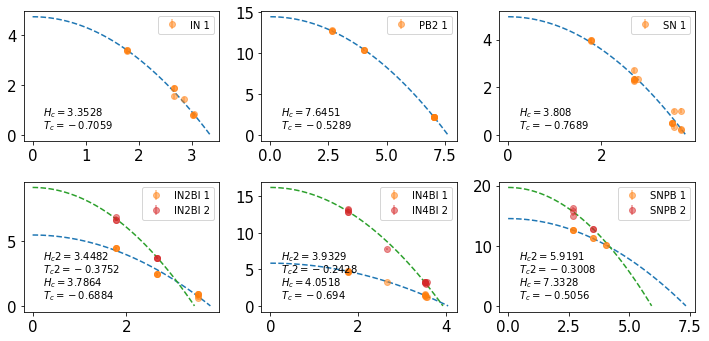

In [142]:
## samples = ['IN','PB2','SNPB','IN2BI','IN4BI', 'SN'] #superconducting
#controls = ["PTFE", "Cu"] #non-superconducting


df_critical_B = pd.read_csv("MeissnerEffectData.csv")


df_critical_B_1 = df_critical_B[['Sample Name', 'Temperature (K)', 'Critical B Field 1']]
df_critical_B_1 = df_critical_B_1.dropna()

df_critical_B_2 = df_critical_B[['Sample Name', 'Temperature (K)', 'Critical B Field 2']]
df_critical_B_2 = df_critical_B_2.dropna()

print(df_critical_B_1)
print(df_critical_B_2)

def dict_temp_critical_B(df_critical_B):
    '''
    Params: dataframe of csv data (name, temp, critical B)
    Returns: Dictionary: Key are sample names. Values are two lists one of temp and one of critical B
    
    '''
    PB0 = [[], []]
    PB1 = [[], []]
    IN = [[], []]
    PB2 = [[], []]
    SNPB = [[], []]
    Cu = [[], []]
    PTFE = [[], []]
    IN2BI = [[], []]
    IN4BI = [[], []]
    SN = [[], []]

    all_samples = {"IN": IN, "PB2": PB2, "SNPB": SNPB, "Cu": Cu, "PTFE": PTFE, "IN2BI": IN2BI, "IN4BI": IN4BI, "SN": SN, "PB0": PB0, "PB1":PB1}
    for index, row in df_critical_B.iterrows(): #add some error bars 
        #print(row)
        key = row["Sample Name"]
        sample = all_samples[key.strip()]
        #print(sample)
        sample[0].append(row['Temperature (K)'])
        try: 
            sample[1].append(row['Critical B Field 1'])
        except KeyError: 
            sample[1].append(row['Critical B Field 2'])
    
    return all_samples


first_curve_samples = dict_temp_critical_B(df_critical_B_1) #moving all csv data into dictionary
print(first_curve_samples)
second_curve_samples = dict_temp_critical_B(df_critical_B_2)
print(second_curve_samples)


subplots = {"IN": (0,0), "PB2": (0,1), "SNPB": (1,2), "IN2BI": (1,0), "IN4BI": (1,1), "SN": (0,2)}
# def plot_sample_dict(all_samples):

fig, axes = plt.subplots(2, 3, figsize=(10,5))

def Hc_from_T(T, Hc0, Tc0):
    return Hc0*(1-(T/Tc0)**2)

for key in all_samples:
    #print(key)
    #print(all_samples[key][0])

    if key not in ["PB0", "PB1", "PTFE", "Cu"]: #excluding the non-superconducting samples or the samples we don't want to look at
        
        r,c = subplots[key]
        ax = axes[r,c]
        for n, data in {1:first_curve_samples, 2:second_curve_samples}.items():
            x_meissner = data[key][0]
            y_meissner = data[key][1]

            if len(x_meissner) != 0:
                x_meissner = pd.Series(x_meissner)
                y_meissner = pd.Series(y_meissner)

                sigma = []
                for i in range(len(x_meissner)):
                    sigma.append(.1)

                sigma = pd.Series(sigma)

                popt, pcov = curve_fit(Hc_from_T, x_meissner, y_meissner, p0=(10,3),sigma=sigma)
                Hc0, Tc0 = popt
                
                xrange = np.linspace(0,Tc0,50)
                ax.plot(xrange, Hc_from_T(xrange, *popt),'--')
                ax.errorbar(x_meissner, y_meissner, ls='none', yerr= .1, fmt='o', alpha = 0.5, label=key+f' {n}')
#                 ax.scatter(x_meissner, y_meissner, s=10 , color = 'red',zorder=100)

        #         -b/m = x

                print(key, "Critical B Field at Zero Temperature", func(0, *popt) )
                print(key, "Critical Temperature with Zero B Field ", -popt[1]/popt[0])

                if n == 1:
                    ax.annotate(f'$H_c = {round(Hc0,4)}$', (0.1,0.2), xycoords='axes fraction',size=10)
                    ax.annotate(f'$T_c = {round(Tc0,4)}$', (0.1,0.1), xycoords='axes fraction', size=10)
                if n == 2:
                    ax.annotate(f'$H_c2 = {round(Hc0,4)}$', (0.1,0.4), xycoords='axes fraction',size=10)
                    ax.annotate(f'$T_c2 = {round(Tc0,4)}$', (0.1,0.3), xycoords='axes fraction', size=10)
#                 plt.xlabel("Temperature (K)")
#                 plt.ylabel("Critical B Field (kG)")
#                 plt.title(key)
                ax.legend(fontsize=10)
#                 ax.set_xlim(0,4.5)
#                 ax.set_ylim(0,17)
            else: 
                pass 
plt.tight_layout()
# plt.legend()

# Pb	Element	7.19	0.08
# Bi	Element	5.3×10−4	5.2×10−6
# In	Element	3.4	0.03
# plot_sample_dict(first_curve_samples)


In [ ]:
def Hc_from_T(Hc0, Tc0, T):
    return Hc0*(1-(T/Tc0)**2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


IN Critical B Field at Zero Temperature 6.992444206807426
IN Critical Temperature with Zero B Field  3.4985331508457937
PB2 Critical B Field at Zero Temperature 19.76680119398343
PB2 Critical Temperature with Zero B Field  7.970381605334301
SNPB Critical B Field at Zero Temperature 17.344012268836774
SNPB Critical Temperature with Zero B Field  9.750971171132829
SNPB Critical B Field at Zero Temperature 24.91949411764707
SNPB Critical Temperature with Zero B Field  7.191569714803075
IN2BI Critical B Field at Zero Temperature 8.115983191279891
IN2BI Critical Temperature with Zero B Field  3.9009109381834857
IN2BI Critical B Field at Zero Temperature 12.849969696969707
IN2BI Critical Temperature with Zero B Field  3.744362030905075
IN4BI Critical B Field at Zero Temperature 8.118593844577484
IN4BI Critical Temperature with Zero B Field  4.281964071352645
IN4BI Critical B Field at Zero Temperature 22.956542458469713
IN4BI Critical Temperature with Zero B Field  4.1000078420685675
SN Criti

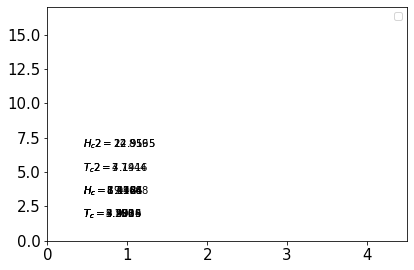

In [134]:

for key in all_samples:
    #print(key)
    #print(all_samples[key][0])

    if key not in ["PB0", "PB1", "PTFE", "Cu"]: #excluding the non-superconducting samples or the samples we don't want to look at
        for n, data in {1:first_curve_samples, 2:second_curve_samples}.items():
            x_meissner = data[key][0]
            y_meissner = data[key][1]

            if len(x_meissner) != 0:
                x_meissner = pd.Series(x_meissner)
                y_meissner = pd.Series(y_meissner)

                sigma = []
                for i in range(len(x_meissner)):
                    sigma.append(.1)

                sigma = pd.Series(sigma)

                popt, pcov = curve_fit(func, x_meissner, y_meissner, sigma= sigma)

                xrange = np.linspace(min(x_meissner),max(x_meissner),50)
                ax.plot(xrange, func(xrange, *popt),'--')
                ax.errorbar(x_meissner, y_meissner, ls='none', yerr= .1, fmt='o', alpha = 0.5, label=key+f' {n}')
#                 ax.scatter(x_meissner, y_meissner, s=10 , color = 'red',zorder=100)

        #         -b/m = x

                print(key, "Critical B Field at Zero Temperature", func(0, *popt) )
                print(key, "Critical Temperature with Zero B Field ", -popt[1]/popt[0])

                if n == 1:
                    plt.annotate(f'$H_c = {round(func(0, *popt),4)}$', (0.1,0.2), xycoords='axes fraction',size=10)
                    plt.annotate(f'$T_c = {round(-popt[1]/popt[0],4)}$', (0.1,0.1), xycoords='axes fraction', size=10)
                if n == 2:
                    plt.annotate(f'$H_c2 = {round(func(0, *popt),4)}$', (0.1,0.4), xycoords='axes fraction',size=10)
                    plt.annotate(f'$T_c2 = {round(-popt[1]/popt[0],4)}$', (0.1,0.3), xycoords='axes fraction', size=10)
#                 plt.xlabel("Temperature (K)")
#                 plt.ylabel("Critical B Field (kG)")
#                 plt.title(key)
                plt.legend(fontsize=10)
                plt.xlim(0,4.5)
                plt.ylim(0,17)
            else: 
                pass 
plt.tight_layout()
# plt.legend()


start of type 2 samples
SNPB Critical B Field at Zero Temperature 24.91949411764707
SNPB Critical Temperature with Zero B Field  7.191569714803075
IN2BI Critical B Field at Zero Temperature 12.849969696969707
IN2BI Critical Temperature with Zero B Field  3.744362030905075
IN4BI Critical B Field at Zero Temperature 22.956542458469713
IN4BI Critical Temperature with Zero B Field  4.1000078420685675


<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

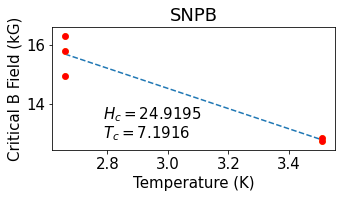

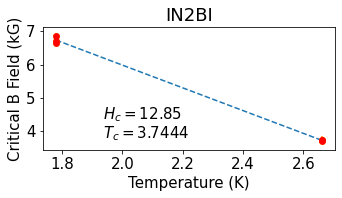

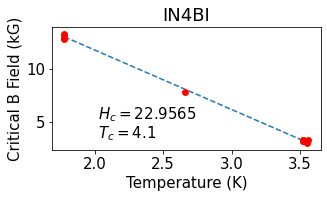

<Figure size 360x216 with 0 Axes>

In [113]:
print("start of type 2 samples")
plot_sample_dict(second_curve_samples)

In [114]:
        x_meissner_array = np.array(x_meissner)
        y_meissner_array = np.array(y_meissner)
        #print(x_meissner_array)
        #print(y_meissner_array)
        #print(len(x_meissner_array))
        #print(len(y_meissner_array))
        
        x_meissner_array = x_meissner_array.reshape(-1, 1)
        y_meissner_array = y_meissner_array.reshape(-1, 1)
        
        fit = LinearRegression().fit(x_meissner_array, y_meissner_array)  # perform linear regression
        y_pred_meissner_array = fit.predict(x_meissner_array)  # make predictions
        plt.plot(x_meissner_array, y_pred_meissner_array, color='purple', linewidth = 1 )
        plt.errorbar(x_meissner, y_meissner, yerr = .1, xerr = .1) #what is the error on the calibration????
        m_meissner = float(fit.coef_)
        b_meissner = float(fit.intercept_)
        

NameError: name 'LinearRegression' is not defined